In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import sys
sys.path.insert(0,"../src_fork/")
sys.path.insert(0,"../tests/")

import linear_regression
import utils
import unit_tests
import linear_regression
import stat_tools
from FrankeFunction import FrankeFunction


FIGPATH = "../figs/"

# Make sure things are working as expected
unit_tests.OLS_unit_test()
unit_tests.OLS_SVD_unit_test()
unit_tests.Ridge_unit_test()

In [2]:
# Generate test data
n = 500 # Number of data points

x_dat = np.random.uniform(0, 1, n)
y_dat = np.random.uniform(0, 1, n)
z_dat = FrankeFunction(x_dat, y_dat)

# Set up the scaler
scaler = StandardScaler()

In [3]:
# Wrap the analysis in a function to duplicate for Clean & Noisy data
def p1_analysis(x, y, z, degrees):
    mse = pd.DataFrame(columns=["train", "test"], index = degrees)
    r2 = pd.DataFrame(columns=["train", "test"], index = degrees)
    
    max_num_betas = int((degrees[-1] + 1) * (degrees[-1] + 2) / 2)
    betas = np.zeros([len(degrees), max_num_betas])
    var_betas = np.zeros([len(degrees), max_num_betas])

    for i, deg in enumerate(degrees):
        X = linear_regression.design_matrix_2D(x, y, deg)
        # Split data, but don't shuffle. OK since data is already randomly sampled! 
        # Fasilitates a direct comparrison of the clean & Noisy data
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2, shuffle=False)
        # Normalize data sets
        X_train = scaler.fit_transform(X_train)
        X_train[:, 0] = np.ones(X_train.shape[0])
        X_test = scaler.fit_transform(X_test)
        X_test[:, 0] = np.ones(X_test.shape[0])

        beta = linear_regression.OLS_SVD_2D(X_train, z_train)
    
        mse["train"][i] = stat_tools.MSE(z_train, X_train @ beta)
        mse["test"][i] = stat_tools.MSE(z_test, X_test @ beta)
        r2["train"][i] = stat_tools.R2(z_train, X_train @ beta)
        r2["test"][i] = stat_tools.R2(z_test, X_test @ beta)
        
        betas[i, 0:len(beta)] = beta
        var_betas[i, 0:len(beta)] = stat_tools.var_beta(X_train, 0.2)

    return mse, r2, betas, var_betas

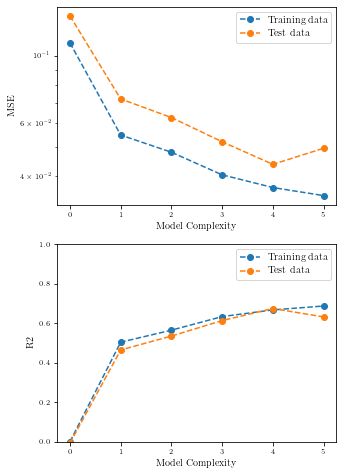

In [4]:
c = 5

degrees = np.arange(0, c+1) # Degrees of the polynom

# Generate data
MSE_clean, R2_clean, betas, var_betas = p1_analysis(
    x_dat, y_dat, z_dat + np.random.normal(0, 1, n) * 0.2, degrees
)

plt.figure(figsize=(5,8))
plt.tight_layout()
# Plot MSE
plt.subplot(211)
plt.semilogy(degrees, MSE_clean["train"],"o--", label = "Training data")
plt.semilogy(degrees, MSE_clean["test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.legend()
# Plot R2
plt.subplot(212)
plt.plot(degrees, R2_clean["train"],"o--", label = "Training data")
plt.plot(degrees, R2_clean["test"],"o--", label = "Test data")
plt.xlabel("Model Complexity")
plt.ylabel("R2")
plt.ylim([0,1])
plt.legend()

In [1]:
plt.figure(figsize=(6,2))

for c in range(0, 5+1):
    indx = np.arange(0, utils.polynomial_no_terms(c))
    err =  4 * np.sqrt(var_betas[c][0:utils.polynomial_no_terms(c)])

    plt.plot(indx, err, "o--")
plt.xlabel("i")
plt.ylabel("$4\\sigma$")
plt.xticks(np.arange(0, 21), utils.polynomial_form(5), rotation=20)
plt.grid()
plt.title("REDO THIS (But possible link with Variance)")

plt.savefig(FIGPATH+"beta_confidence_interval_size_OLS.pdf")

plt.figure(figsize=(6,2))
plt.errorbar(indx, betas[c][0:utils.polynomial_no_terms(c)],
            yerr=err,
            fmt="o",
            capsize=5
            )
#plt.ylim([-10, 10])
#plt.xlabel("Term")
""""
terms = utils.polynomial_form(c)
for i in range(21):
    plt.annotate(terms[i], xy=(i, betas[c][i]))
"""

plt.ylabel("$\\beta_i$")
plt.grid("on")
plt.xticks(np.arange(0, 21), utils.polynomial_form(c), rotation=20)
plt.savefig(FIGPATH+"beta_confidence_interval_OLS.pdf")
plt.show()

NameError: name 'plt' is not defined

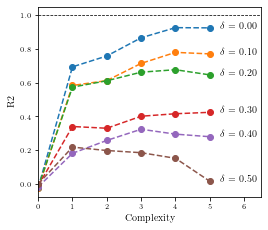

In [6]:
noises = np.linspace(0, .5, 6)
degrees = np.arange(0, 6)

plt.figure(figsize=[4, 3.5])

for noise in noises:
    # Generate a new noisy dataset
    z_dat_noisy = z_dat + np.random.normal(0, 1, n) * noise
    MSE_noisy, R2_noisy, _, _ = p1_analysis(x_dat, y_dat, z_dat_noisy,degrees)
    
    plt.plot(degrees, R2_noisy["test"], "o--")
    plt.annotate("$\delta=$ %.2f" % noise, [degrees[-1] + .3,R2_noisy["test"].iloc[-1]])

plt.xlim([0, degrees[-1] + 1.5])
plt.axhline([1],color="black", ls="--", lw=0.75)
plt.xlabel("Complexity")
plt.ylabel("R2")
plt.savefig(FIGPATH+"OLS_R2_noise.pdf")